The following tutorial is available on the [Wallaroo Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/2023.3.0-updates/pipeline-edge-publish/edge-cv-retail).

## Computer Vision Edge Retail Imaging Deployment Demonstration

This notebook will walk through building a computer vision (CV) pipeline with multiple versions focused on in Wallaroo, deploying it to the local cluster for testing, and then publishing it for edge deployment.

This demonstration will focus on deployment to the edge.  For further examples of using Wallaroo with this computer vision models, see [Use Case Tutorials: Computer Vision: Retail](https://docs.wallaroo.ai/wallaroo-use-case-tutorials/wallaroo-use-case-computer-vision/use-case-computer-vision-retail/).

This demonstration will perform the following:

1. As a Data Scientist:
    1. Upload a Mobilenet computer vision model to Wallaroo, deploy it in a Wallaroo pipeline, then perform a sample inference.  The version of the pipeline will be stored.
    1. Upload a Resnet computer vision model to Wallaroo, deploy  it in a Wallaroo pipeline, then perform a sample inference.  The version of the pipeline will be stored.
    1. Publish each versions of the pipeline to an Open Container Initiative (OCI) Registry service.  This is configured in the Wallaroo instance.  See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.
    1. View the pipeline publish details.
1. As a DevOps Engineer:
    1. Deploy the published pipelines into an edge instances using the different versions.  This example will use Docker.
    1. Perform a sample inference into the deployed pipeline with the same data used in the data scientist example.

## Data Scientist Pipeline Publish Steps

### Load Libraries

The first step is to import the libraries used in this notebook.

In [19]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
from wallaroo.framework import Framework

import json

import datetime
import time

# used for unique connection names

import string
import random

import pyarrow as pa

import sys
 
# setting path - only needed when running this from the `with-code` folder.
# sys.path.append('../')

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "./models/coco_classes.pickle"


### Connect to the Wallaroo Instance through the User Interface

The next step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [ ]:
wl = wallaroo.Client()

### Create a New Workspace

We'll use the SDK below to create our workspace , assign as our **current workspace**, then display all of the workspaces we have at the moment.  We'll also set up variables for our models and pipelines down the road, so we have one spot to change names to whatever fits your organization's standards best.

To allow this tutorial to be run by multiple users in the same Wallaroo instance, a random 4 character prefix will be added to the workspace, pipeline, and model.  Feel free to set `suffix=''` if this is not required.

In [10]:
import string
import random

# make a random 4 character prefix
suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

suffix='john'

workspace_name = f'edge-cv-retail-demo{suffix}'
pipeline_name = 'edge-cv-retail'
model_name = 'resnet-50'
model_file_name = './models/resnet50_v1.onnx'

In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'edge-cv-retail-demojohn', 'id': 15, 'archived': False, 'created_by': 'fa240e86-5fb9-4d58-bf5d-f82bf0b2b172', 'created_at': '2023-09-06T16:24:36.900271+00:00', 'models': [], 'pipelines': []}

### Upload the Model

When a model is uploaded to a Wallaroo cluster, it is optimized and packaged to make it ready to run as part of a pipeline. In many times, the Wallaroo Server can natively run a model without any Python overhead. In other cases, such as a Python script, a custom Python environment will be automatically generated. This is comparable to the process of "containerizing" a model by adding a small HTTP server and other wrapping around it.

Our pretrained models are in ONNX format, which is specified in the `framework` parameter.

We will also include a Python step that is used to detect model drift.  Each version of the pipeline will include both the CV model and the python step.

In [7]:
## blank space to upload model, and create the pipeline

mobilenet_model_name = 'mobilenet'
mobilenet_model_path = "./models/mobilenet.pt.onnx"

mobilenet_model = wl.upload_model(mobilenet_model_name, 
                                  mobilenet_model_path, 
                                  framework=Framework.ONNX).configure('onnx', 
                                                                      batch_config="single"
                                                                      )

resnet_model_name = 'resnet50'
resnet_model_path = "./models/frcnn-resnet.pt.onnx"

resnet_model = wl.upload_model(mobilenet_model_name, 
                                  mobilenet_model_path, 
                                  framework=Framework.ONNX).configure('onnx', 
                                                                      batch_config="single"
                                                                      )



# upload python step

field_boxes = pa.field('boxes', pa.list_(pa.list_(pa.float64(), 4)))
field_classes = pa.field('classes', pa.list_(pa.int32()))
field_confidences =  pa.field('confidences', pa.list_(pa.float64()))

# field_boxes - will have a flattened array of the 4 coordinates representing the boxes.  128 entries
# field_classes - will have 32 entries
# field_confidences - will have 32 entries
input_schema = pa.schema([field_boxes, field_classes, field_confidences])

output_schema = pa.schema([
    field_boxes,
    field_classes,
    field_confidences,
    pa.field('avg_conf', pa.list_(pa.float64()))
])

module_post_process = wl.upload_model("cv-post-process-drift-detection", 
                                      "./models/post-process-drift-detection-arrow.py",
                                      framework=Framework.PYTHON ).configure('python', 
                                                                             input_schema=input_schema, 
                                                                             output_schema=output_schema
                                    )

### Reserve Pipeline Resources

Before deploying an inference engine we need to tell wallaroo what resources it will need.
To do this we will use the wallaroo DeploymentConfigBuilder() and fill in the options listed below to determine what the properties of our inference engine will be.

We will be testing this deployment for an edge scenario, so the resource specifications are kept small -- what's the minimum needed to meet the expected load on the planned hardware.

- cpus - 4 => allow the engine to use 4 CPU cores when running the neural net
- memory - 2Gi => each inference engine will have 2 GB of memory, which is plenty for processing a single image at a time.
- arch - we will specify the X86 architecture.

In [8]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
    .cpus(4)\
    .memory("2Gi")\
    .arch(wallaroo.engine_config.Architecture.X86)\
    .build()

### Simulated Edge Deployment

We will now deploy our pipeline into the current Kubernetes environment using the specified resource constraints. This is a "simulated edge" deploy in that we try to mimic the edge hardware as closely as possible.

We will do it with Mobilenet first.

In [11]:
# create the pipeline
pipeline = get_pipeline(pipeline_name)

# undeploy and clear if used in other demos
pipeline.undeploy()
pipeline.clear()

# set the mobilenet version of the pipeline
pipeline.add_model_step(mobilenet_model)
pipeline.add_model_step(module_post_process)
pipeline.deploy(deployment_config = deployment_config)

name,edge-cv-retail
created,2023-09-06 16:28:19.095930+00:00
last_updated,2023-09-06 16:28:19.095930+00:00
deployed,True
tags,
versions,da74f2ca-978f-47ac-a656-44697bd0afbb
steps,mobilenet
published,False


In [12]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.2.199',
   'name': 'engine-76bf7566d6-6mnlp',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'edge-cv-retail',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'mobilenet',
      'version': '1fbeeb7b-dbc6-40fc-b5a9-24e22742ee6c',
      'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830',
      'status': 'Running'},
     {'name': 'cv-post-process-drift-detection',
      'version': '9d2043ab-ea90-4cde-ae7d-8e33468b61cd',
      'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.4.160',
   'name': 'engine-lb-584f54c899-7x72j',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

### Store the Pipeline Version

We will store the pipeline version for later publication.

In [13]:
mobilenet_pipeline_version = pipeline.versions()[0]
mobilenet_pipeline_version

name,edge-cv-retail
version,da74f2ca-978f-47ac-a656-44697bd0afbb
creation_time,2023-06-Sep 16:28:19
last_updated_time,2023-06-Sep 16:28:19
deployed,False
tags,
steps,mobilenetcv-post-process-drift-detection


### Run Single Image Inference

A single image, encoded using the Apache Arrow format, is sent to the deployed pipeline. Arrow is used here because, as a binary protocol, there is far lower network and compute overhead than using JSON. The Wallaroo Server engine accepts pandas DataFrame and Apache Arrow formats.

This example will use a converter function from the `CVDemoUtils.py` module to convert the sample image into a DataFrame, then submit it for inferencing.

In [17]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

mobilenetResults = pipeline.infer(dfImage)

### Render the Image

If using our sample models, this inference has returned the following fields:

* `out.boxes`: An array of the bounding boxes for detected objects.
* `out.classes`: Identifies the type of object detected.
* `out.confidences`: Displays the confidence level the model has in its classification.
* `out.avg_conf`: An average of all of the confidence values.

The provides `CVDemoUtils` contains a handy method `cvDemo.drawDetectedObjectsFromInference(results)` that takes these values and combines then with the images to show the bounding boxes of detected objects.  Not that `inf-results` requires the inference results derived earlier.

```python
elapsed = 1.0

sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : results,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)
```

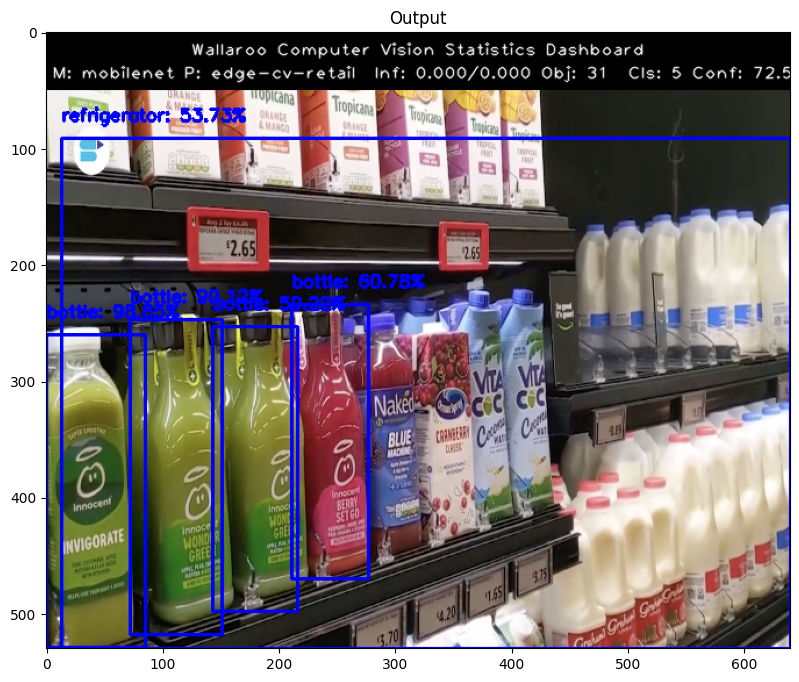

In [20]:
elapsed = 1.0

sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : mobilenetResults,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

In [23]:
# display the confidence values

display(mobilenetResults.loc[:, ['out.avg_conf']])

,out.avg_conf
0,[0.2895053208114637]


### Resnet50 Version of the Pipeline

We will now clear the pipeline steps, and redeploy the pipeline with the Resnet50 model.

Once done, we'll re-render the image, and store that version of the pipeline for publication.

In [24]:
# set the mobilenet version of the pipeline
pipeline.clear()
pipeline.add_model_step(resnet_model)
pipeline.add_model_step(module_post_process)
pipeline.deploy()

# add a few more seconds to verify the swap is complete
time.sleep(10)

,out.avg_conf
0,[0.2895053208114637]


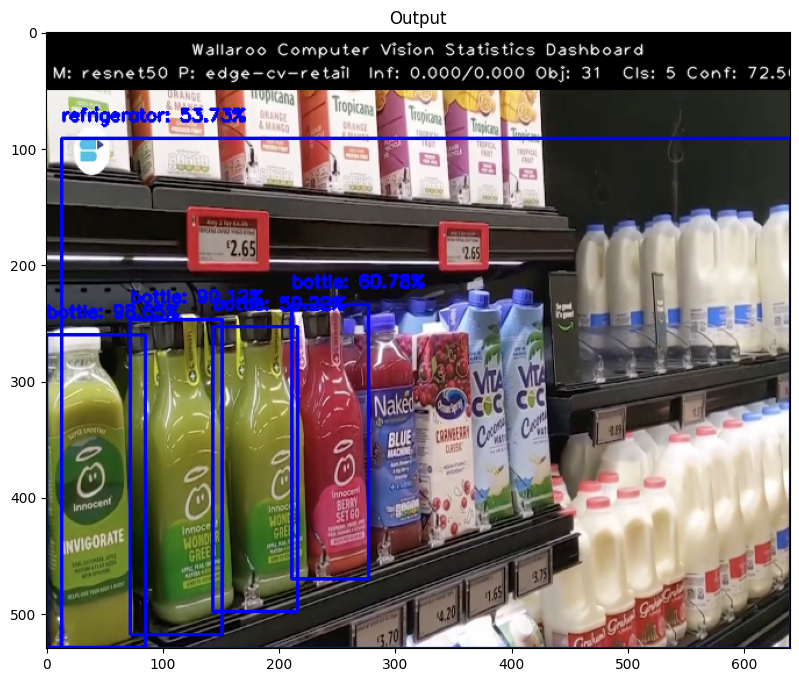

In [26]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

resnetResults = pipeline.infer(dfImage)

# display the confidence values
display(resnetResults.loc[:, ['out.avg_conf']])
elapsed = 1.0

sample = {
    'model_name' : resnet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : resnetResults,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

In [27]:
resnet_pipeline_version = pipeline.versions()[0]
resnet_pipeline_version

name,edge-cv-retail
version,6c0a3dbe-e845-410b-92cb-87468e508b3f
creation_time,2023-06-Sep 16:31:26
last_updated_time,2023-06-Sep 16:31:26
deployed,False
tags,
steps,mobilenetcv-post-process-drift-detection


### Undeploy Pipeline

We have tested out the inferences, so we'll undeploy the pipeline to retrieve the system resources.

In [25]:
## blank space to undeploy the pipeline, if needed

pipeline.undeploy()


name,cv-retail-pipeline
created,2023-08-04 19:23:11.179176+00:00
last_updated,2023-08-04 19:43:05.131579+00:00
deployed,False
tags,
versions,"9eb22dbc-c035-4ac4-bba9-b7cd3a9f30ba, 5ce99fc6-4463-4ab0-abbe-8b490ce9fc29, 8faa0d21-11ed-4186-8f5d-a586ead7ab00, 305db319-db20-4be8-94a7-ecb3d8bee4d4, 15cc7825-03a1-4794-8a31-744d290db193"
steps,mobilenet


### Publish the Pipeline for Edge Deployment

It worked! For a demo, we'll take working once as "tested". So now that we've tested our pipeline, we are ready to publish it for edge deployment.

Publishing it means assembling all of the configuration files and model assets and pushing them to an Open Container Initiative (OCI) repository set in the Wallaroo instance as the Edge Registry service.  DevOps engineers then retrieve that image and deploy it through Docker, Kubernetes, or similar deployments.

See [Edge Deployment Registry Guide](https://staging.docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/) for details on adding an OCI Registry Service to Wallaroo as the Edge Deployment Registry.

This is done through the SDK command `wallaroo.pipeline.publish(deployment_config)`.  This publishes the most recent **pipeline version**.  The alternate method is to use the `wallaroo.pipeline_variant.publish(deployment_config)`, which specifies the pipeline version to publish.

#### Publish a Pipeline Parameters

The `wallaroo.pipeline.publish(deployment_config)` method takes the following parameters.  The containerized pipeline will be pushed to the Edge registry service with the model, pipeline configurations, and other artifacts needed to deploy the pipeline.

| Parameter | Type | Description |
|---|---|---|
| `deployment_config` | `wallaroo.deployment_config.DeploymentConfig` (*Optional*) | Sets the pipeline deployment configuration.  For example:    For more information on pipeline deployment configuration, see the [Wallaroo SDK Essentials Guide: Pipeline Deployment Configuration]({{<ref "wallaroo-sdk-essentials-pipeline-deployment-config">}}).

#### Publish a Pipeline Returns

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline version id | integer | Numerical Wallaroo id of the pipeline version published. |
| status | string | The status of the pipeline publication.  Values include:  <ul><li>PendingPublish: The pipeline publication is about to be uploaded or is in the process of being uploaded.</li><li>Published:  The pipeline is published and ready for use.</li></ul> |
| Engine URL | string | The URL of the published pipeline engine in the edge registry. |
| Pipeline URL | string | The URL of the published pipeline in the edge registry. |
| Helm Chart URL | string | The URL of the helm chart for the published pipeline in the edge registry. |
| Helm Chart Reference | string | The help chart reference. |
| Helm Chart Version | string | The version of the Helm Chart of the published pipeline.  This is also used as the Docker tag. |
| Engine Config | `wallaroo.deployment_config.DeploymentConfig` | The pipeline configuration included with the published pipeline. |
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

### Publish Example

We will now publish the pipeline to our Edge Deployment Registry with the `pipeline.publish(deployment_config)` command.  `deployment_config` is an optional field that specifies the pipeline deployment.  This can be overridden by the DevOps engineer during deployment.

We will publish both versions of our pipeline and display the details.

In [28]:
mobilenet_publish = mobilenet_pipeline_version.publish()
display(mobilenet_publish)
resnet_publish = resnet_pipeline_version.publish()
display(resnet_publish)

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing...Published.


ID,9
Pipeline Version,da74f2ca-978f-47ac-a656-44697bd0afbb
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:da74f2ca-978f-47ac-a656-44697bd0afbb
Helm Chart URL,ghcr.io/wallaroolabs/doc-samples/charts/edge-cv-retail
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:fd851906ebfa7f0e9bbb414cf8e5d74d453aaf93c6d832211ee494b4b210693d
Helm Chart Version,0.0.1-da74f2ca-978f-47ac-a656-44697bd0afbb
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing..Published.


ID,10
Pipeline Version,6c0a3dbe-e845-410b-92cb-87468e508b3f
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:6c0a3dbe-e845-410b-92cb-87468e508b3f
Helm Chart URL,ghcr.io/wallaroolabs/doc-samples/charts/edge-cv-retail
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:5cf4c3f16e800682207e9c78608319d18fc9648f43eb5017f9d4481c48ce8194
Helm Chart Version,0.0.1-6c0a3dbe-e845-410b-92cb-87468e508b3f
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


### List Published Pipeline

The method `wallaroo.client.list_pipelines()` shows a list of all pipelines in the Wallaroo instance, and includes the `published` field that indicates whether the pipeline was published to the registry (`True`), or has not yet been published (`False`).

In [29]:
wl.list_pipelines()

name,created,last_updated,deployed,tags,versions,steps,published
edge-cv-retail,2023-06-Sep 16:28:19,2023-06-Sep 16:31:26,True,,"6c0a3dbe-e845-410b-92cb-87468e508b3f, da74f2ca-978f-47ac-a656-44697bd0afbb",mobilenet,True
cv-retail-pipeline,2023-06-Sep 16:27:43,2023-06-Sep 16:27:43,(unknown),,616fad1d-8936-4f25-bf59-199681425fc0,,False
resnetnetpipelinejohn,2023-05-Sep 21:17:41,2023-05-Sep 21:18:01,False,,"70d81f23-8bb7-4623-92db-6be7a89178c2, 6f3539cc-bbe7-4326-b116-3c8dfb99c7b6",resnet50john,False
resnetnetpipelinedyqp,2023-05-Sep 21:12:15,2023-05-Sep 21:12:34,False,,"fd7b4c2e-5ced-4dbf-9d5e-adcef31e2886, 9c77146e-4a70-47bd-9a99-db1d0992f29f",resnet50dyqp,False
housing-pipe,2023-05-Sep 18:08:50,2023-05-Sep 19:05:23,False,,"671acb30-b6f3-4b24-83ed-390b9aaa29fd, 7341d56f-d9e0-45e6-ad07-a36b136264d1, d7f48b2c-93f4-48d3-80b6-399c30eeb3d7, 8f199fb9-cb4b-4e2b-9a91-35c002016018, dc3351f3-408d-46a4-b761-d22d24f83a2b, 6006adf0-3244-4490-9fd6-229a86c72a73, c81ee0b1-bb26-40ea-bba0-c1eab788f41f, fa1f1348-0b8a-46c7-8c4c-dde666a2ca41",housepricemodel,False
demandcurvepipeline,2023-01-Sep 19:35:46,2023-05-Sep 17:19:38,False,,"0304ba8d-d1ff-47e6-acfc-b68454d09126, e4607e83-d2e1-4809-9047-a5f5d5d27468, 4d0da913-59fb-4e99-9d6b-1c18377ab34c, 9d5076cb-5752-43ab-af4f-4c904d06ba52, d06a9550-d693-445a-a6cd-b55635018c57, c95ee014-f431-4d8d-ab99-669fde88173d, bd0c6894-63bc-4cb9-b378-390640307a36, 4136fa8b-270e-49d6-836e-75f7c9c73def, 00a4fb64-302d-4a27-90ac-86e08fb6afe8, 94f0129f-f9c1-474a-89fa-7110c81c9a22, 701a759d-6d45-4d61-bfd0-b878d9a09fc3, 4a85b06f-9051-48ff-9f9e-6b6e4e4b8d68, 698c13e2-4120-4132-b72b-99cd8c0fdd99, 1314a1a4-eabc-437d-bf3f-83f54686970e",demandcurvemodel,False
python-step-demo-pipeline,2023-01-Sep 15:48:11,2023-01-Sep 18:50:25,False,,"44bb2976-b307-4e8f-b8a0-f028c9255ab7, 815ef232-0e4f-45b1-b4a5-9679b4ba8ed0, 39994c6a-9761-4476-934c-7d7c94897db4, 833d7d24-bb6d-43b6-91c6-29bcc0004f7c, c3b5b89f-e016-4865-b90b-2bff6cd536ed, 80e183b1-22a6-40f6-ad6c-b4c53b41cd35, 12d9c671-2bca-4640-8f64-9052caadd2bb, bedec102-7200-450d-a9c2-99b4e8555cae, 8371afaf-cf69-40e2-a726-8c24cd887bd9, f457495f-263f-406f-b502-ffc01e6138c8, 14cd53dd-8ad7-452d-bd10-c44bf3e95e15, 5da24f74-5bc7-47a1-8ac1-7312995e8e9d, 18987451-2eb3-468d-a96a-f306a34129b6, 216e8b67-eda4-4450-84f8-b24905776448, 4d09e34b-54e6-4c2e-ae1d-041b8d33acf6, 2f9ff270-a7f8-4f06-9bcf-90c0877b4957, c94b87bf-b221-4c45-b2f7-4b4021218e19, 8238e0da-6dd3-47a0-8661-0c886f00c3e2, c41db9ec-7774-4a6b-8206-6b05ef52cf98, d98e991d-3550-4b40-92ac-f0cd07580ce9, 1ce2de97-5648-411c-be41-fc134f3f200d, caa02027-a873-461c-8544-8284543002a2, 4bf6a189-0e3d-4d74-b1c9-d388fe32ce66, 15c60445-7611-42fb-980a-866d119fe8df, ce822e5d-6339-46b6-a274-5e99f6095e62, b89071c7-c3bb-4a4a-91e3-85dadde74ebc, 0238ab79-4e0f-40ab-9408-5c78df6ad089, 31c00f3d-3c64-4266-984d-9512a3c93cb2, c91cff5e-c20d-4040-9405-c63248b93a43, 5910be7a-09ef-4b99-9a90-b0f5992c3d0a, 3c672ce0-67a1-413d-9230-e4d01e4856cd, 5882fd2c-f456-4d47-9deb-d31cca08c5a2",house-price-sample,False
edge-pipeline,2023-31-Aug 22:46:35,2023-31-Aug 22:46:48,True,,"799544c6-24b1-4a85-8d83-b78392f86333, 5ca59e22-8608-4251-a308-3cdafc6b370a, 26af31d5-fe31-4c45-bdd9-9416f7cdb21a",ccfraud,True
vgg16-clustering-pipeline,2023-31-Aug 22:22:25,2023-31-Aug 22:25:35,False,,"32e52139-42c9-4cf9-969d-fcf1f0d4d695, 1bb2f66b-5c02-47e7-8845-ebf1718830fa, 332e239e-93ea-41a3-8791-076719124403",vgg16-clustering,True
edge-cv-retail,2023-31-Aug 22:19:08,2023-05-Sep 21:40:43,False,,"ba05b2f9-e430-4b8d-bbc2-3ac6d088ccf3, b4e182b3-2f40-46e1-a354-ee5a8e8c2712, cebc1047-c76b-4e72-83c8-ee25e202c2ae, c8bbda27-baea-4226-9c1b-13001be84b66, 5ac1b0e9-1886-4458-bacd-731f99f73719, 60025d35-3f06-47b3-b46f-f18b1e20da33, 5d7ae40a-60f8-4e0f-8b8d-2f77cb3321da, 67a76859-52f6-45d4-af2b-a218636fea79, 57df9910-76f7-4b46-b791-522961daa0ed, ff51f3c9-f634-451c-9aec-4b7787cd5ec9, 1a1ff363-e86f-46c5-b2b4-240bf3866f1b",resnet-50,True


### List Publishes from a Pipeline

All publishes created from a pipeline are displayed with the `wallaroo.pipeline.publishes` method.  The `pipeline_version_id` is used to know what version of the pipeline was used in that specific publish.  This allows for pipelines to be updated over time, and newer versions to be sent and tracked to the Edge Deployment Registry service.

#### List Publishes Parameters

N/A

#### List Publishes Returns

A List of the following fields:

| Field | Type | Description |
|---|---|---|
| id | integer | Numerical Wallaroo id of the published pipeline. |
| pipeline_version_id | integer | Numerical Wallaroo id of the pipeline version published. |
| engine_url | string | The URL of the published pipeline engine in the edge registry. |
| pipeline_url | string | The URL of the published pipeline in the edge registry. |
| created_by | string | The email address of the user that published the pipeline.
| Created At | DateTime | When the published pipeline was created. |
| Updated At | DateTime | When the published pipeline was updated. |

In [30]:
pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
9,da74f2ca-978f-47ac-a656-44697bd0afbb,ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771,ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:da74f2ca-978f-47ac-a656-44697bd0afbb,john.hummel@wallaroo.ai,2023-06-Sep 16:55:02,2023-06-Sep 16:55:02
10,6c0a3dbe-e845-410b-92cb-87468e508b3f,ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771,ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:6c0a3dbe-e845-410b-92cb-87468e508b3f,john.hummel@wallaroo.ai,2023-06-Sep 16:55:21,2023-06-Sep 16:55:21


## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.

### Docker Deployment

First, the DevOps engineer must authenticate to the same OCI Registry service used for the Wallaroo Edge Deployment registry.

For more details, check with the documentation on your artifact service.  The following are provided for the three major cloud services:

* [Set up authentication for Docker](https://cloud.google.com/artifact-registry/docs/docker/authentication)
* [Authenticate with an Azure container registry](https://learn.microsoft.com/en-us/azure/container-registry/container-registry-authentication?tabs=azure-cli)
* [Authenticating Amazon ECR Repositories for Docker CLI with Credential Helper](https://aws.amazon.com/blogs/compute/authenticating-amazon-ecr-repositories-for-docker-cli-with-credential-helper/)

For the deployment, the engine URL is specified with the following environmental variables:

* `DEBUG` (true|false): Whether to include debug output.
* `OCI_REGISTRY`: The URL of the registry service.
* `CONFIG_CPUS`: The number of CPUs to use.
* `OCI_USERNAME`: The edge registry username.
* `OCI_PASSWORD`:  The edge registry password or token.
* `PIPELINE_URL`: The published pipeline URL.

#### Docker Deployment Example

Using our sample environment, here's sample deployment using Docker with a computer vision ML model, the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```bash
docker run -p 8080:8080 \
    -e DEBUG=true -e OCI_REGISTRY={your registry server} \
    -e CONFIG_CPUS=4 \
    -e OCI_USERNAME=oauth2accesstoken \
    -e OCI_PASSWORD={registry token here} \
    -e PIPELINE_URL={your registry server}/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555 \
    {your registry server}/engine:v2023.3.0-main-3707
```

### Docker Compose Deployment

For users who prefer to use `docker compose`, the following sample `compose.yaml` file is used to launch the Wallaroo Edge pipeline.  This is the same used in the [Wallaroo Use Case Tutorials Computer Vision: Retail]({{<ref "use-case-computer-vision-retail">}}) tutorials.

```yml
services:
  engine:
    image: {Your Engine URL}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {Your Pipeline URL}
      OCI_REGISTRY: {Your Edge Registry URL}
      OCI_USERNAME:  {Your Registry Username}
      OCI_PASSWORD: {Your Token or Password}
      CONFIG_CPUS: 4
```

For example:

```yml
services:
  engine:
    image: sample-registry.com/engine:v2023.3.0-main-3707
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
      OCI_REGISTRY: sample-registry.com
      OCI_USERNAME:  _json_key_base64
      OCI_PASSWORD: abc123
      CONFIG_CPUS: 4
```

#### Docker Compose Deployment Example

The deployment and undeployment is then just a simple `docker compose up` and `docker compose down`.  The following shows an example of deploying the Wallaroo edge pipeline using `docker compose`.

```bash
docker compose up
[+] Running 1/1
 ✔ Container cv_data-engine-1  Recreated                                                                                                                                                                 0.5s
Attaching to cv_data-engine-1
cv_data-engine-1  | Wallaroo Engine - Standalone mode
cv_data-engine-1  | Login Succeeded
cv_data-engine-1  | Fetching manifest and config for pipeline: sample-registry.com/pipelines/edge-cv-retail:bf70eaf7-8c11-4b46-b751-916a43b1a555
cv_data-engine-1  | Fetching model layers
cv_data-engine-1  | digest: sha256:c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   filename: c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984
cv_data-engine-1  |   name: resnet-50
cv_data-engine-1  |   type: model
cv_data-engine-1  |   runtime: onnx
cv_data-engine-1  |   version: 693e19b5-0dc7-4afb-9922-e3f7feefe66d
cv_data-engine-1  |
cv_data-engine-1  | Fetched
cv_data-engine-1  | Starting engine
cv_data-engine-1  | Looking for preexisting `yaml` files in //modelconfigs
cv_data-engine-1  | Looking for preexisting `yaml` files in //pipelines
```

### Helm Deployment

Published pipelines can be deployed through the use of helm charts.

Helm deployments take up to two steps - the first step is in retrieving the required `values.yaml` and making updates to override.

1. Pull the helm charts from the published pipeline.  The two fields are the Helm Chart URL and the Helm Chart version to specify the OCI .    This typically takes the format of:

  ```bash
  helm pull oci://{published.helm_chart_url} --version {published.helm_chart_version}
  ```

1. Extract the `tgz` file and copy the `values.yaml` and copy the values used to edit engine allocations, etc.  The following are **required** for the deployment to run:

  ```yml
  ociRegistry:
    registry: {your registry service}
    username:  {registry username here}
    password: {registry token here}
  ```

  Store this into another file, suc as `local-values.yaml`.

1. Create the namespace to deploy the pipeline to.  For example, the namespace `wallaroo-edge-pipeline` would be:

  ```bash
  kubectl create -n wallaroo-edge-pipeline
  ```

1. Deploy the `helm` installation with `helm install` through one of the following options:
    1. Specify the `tgz` file that was downloaded and the local values file.  For example:

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {tgz path}
        ```

    1. Specify the expended directory from the downloaded `tgz` file.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} {helm directory path}
        ```

    1. Specify the Helm Pipeline Helm Chart and the Pipeline Helm Version.

        ```bash
        helm install --namespace {namespace} --values {local values file} {helm install name} oci://{published.helm_chart_url} --version {published.helm_chart_version}
        ```

1. Once deployed, the DevOps engineer will have to forward the appropriate ports to the `svc/engine-svc` service in the specific pipeline.  For example, using `kubectl port-forward` to the namespace `ccfraud` that would be:

    ```bash
    kubectl port-forward svc/engine-svc -n ccfraud01 8080 --address 0.0.0.0`
    ```

The following code segment generates a `docker compose` template based on the previously published pipeline.

In [31]:
mobilenet_docker_compose = f'''
services:
  engine:
    image: {mobilenet_publish.engine_url}
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: {mobilenet_publish.pipeline_url}
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4
'''

print(mobilenet_docker_compose)

resnet_docker_compose = f'''
services:
  engine:
    image: {resnet_publish.engine_url}
    ports:
      - 8081:8080
    environment:
      PIPELINE_URL: {resnet_publish.pipeline_url}
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4
'''

print(resnet_docker_compose)


services:
  engine:
    image: ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:da74f2ca-978f-47ac-a656-44697bd0afbb
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4


services:
  engine:
    image: ghcr.io/wallaroolabs/doc-samples/engine:v2023.3.0-main-3771
    ports:
      - 8080:8080
    environment:
      PIPELINE_URL: ghcr.io/wallaroolabs/doc-samples/pipelines/edge-cv-retail:6c0a3dbe-e845-410b-92cb-87468e508b3f
      OCI_USERNAME: YOUR USERNAME 
      OCI_PASSWORD: YOUR PASSWORD OR TOKEN
      OCI_REGISTRY: ghcr.io
      CONFIG_CPUS: 4



In [ ]:
## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

```bash
curl localhost:8080/pipelines
{"pipelines":[{"id":"edge-cv-retail","status":"Running"}]}
```

The endpoint `/models` returns a List of models with the following fields:

* **name** (*String*): The model name.
* **sha** (*String*): The sha hash value of the ML model.
* **status** (*String*):  The status of either Running or Error if there are any issues.
* **version** (*String*):  The model version.  This matches the version designation used by Wallaroo to track model versions in UUID format.

```bash
curl localhost:8080/models
{"models":[{"name":"resnet-50","sha":"c6c8869645962e7711132a7e17aced2ac0f60dcdc2c7faa79b2de73847a87984","status":"Running","version":"693e19b5-0dc7-4afb-9922-e3f7feefe66d"}]}
```

The following example uses the host `testboy.local`.  Replace with your own host name of your Edge deployed pipeline.

In [ ]:
!curl testboy.local:8080/pipelines

In [ ]:
!curl testboy.local:8081/pipelines

### Edge Deployed Inference

The inference endpoint takes the following pattern:

* `/pipelines/{pipeline-name}`:  The `pipeline-name` is the same as returned from the [`/pipelines`](#list-pipelines) endpoint as `id`.

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.
* `Content-Type: application/json`: JSON.

The `Accept` header will determine what kind format of the data is returned.
  * `Accept: application/json` Returns a JSON object in the following format.

* **check_failures** (*List[Integer]*): Any Validations that failed.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://staging.docs.wallaroo.ai/20230201/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing)
* **elapsed** (*List[Integer]*): A List of time in nanoseconds for:
  * [0]: The time to serialize the input.
  * [1...n]: How long each step took.
* **model_name** (*String*): The name of the model.
* **model_version** (*String*): The UUID identifier of the model version from Wallaroo.
* **original_data** (*List*): The original submitted data.
* **outputs** (*List*): A List of outputs with each output field corresponding to the input.  This is in the format for each data type returned:
  * **{data-type}**: The data type being returned.
    * **data** (*List*): The data from this data type.
    * **dim** (*List*): The shape of the data for this data type.
* **dim** (*List*): The shape of the data received.
* **pipeline_name** (*String*): The name of the pipeline.
* **shadow_data** (*List*): Any data returned from a shadow deployed model.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Shadow Deployments](https://staging.docs.wallaroo.ai/20230201/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#pipeline-shadow-deployments).
* **time** (*Integer*): The Epoch time of the inference.
  
Once deployed, we can perform an inference through the deployment URL.  Note that our inference endpoint is `pipelines/edge-cv-retail` - the same as our pipeline name.

In [ ]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )



In [ ]:

# set the content type and accept headers
headers = {
    'Content-Type': 'application/json; format=pandas-records'
}

data = dfImage.to_json(orient="records")


host = 'http://testboy.local:8080'

mobilenet_deploy_url = '/pipelines/edge-cv-retail''

response = requests.post(
                mobilenet_deploy_url, 
                headers=headers, 
                data=data, 
                verify=True
            )

# turn this into a dataframe
mobilenetResults = response.json()[0]['outputs'][0]['Float']['data']

In [ ]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

resnetResults = pipeline.infer(dfImage)

# display the confidence values
display(resnetResults.loc[:, ['out.avg_conf']])
elapsed = 1.0

sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : mobilenetResults,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

In [ ]:

# set the content type and accept headers
headers = {
    'Content-Type': 'application/json; format=pandas-records'
}

data = dfImage.to_json(orient="records")


host = 'http://testboy.local:8081'

resnet_deploy_url = '/pipelines/edge-cv-retail''

response = requests.post(
                resnet_deploy_url, 
                headers=headers, 
                data=data, 
                verify=True
            )

resnetResults = response.json()[0]['outputs'][0]['Float']['data']

In [ ]:
##  blank space to create test data, and send some data to your model

image = './data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

resnetResults = pipeline.infer(dfImage)

# display the confidence values
display(resnetResults.loc[:, ['out.avg_conf']])
elapsed = 1.0

sample = {
    'model_name' : resnet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : resnetResults,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

# turn this into a dataframe
image = cvDemo.drawDetectedObjectsFromInference(sample)